In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime
import os

## 데이터 불러오기

https://www.kaggle.com/datasets/ninetyninenewton/kr3-korean-restaurant-reviews-with-ratings/data

In [13]:
import pandas as pd

file_path = '/content/drive/MyDrive/big_project/archive/kr3.tsv'
df = pd.read_csv(file_path, sep='\t')

In [14]:
df

,Rating,Review
0,1,숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1,1,고기가 정말 맛있었어요! 육즙이 가득 있어서 너무 좋았아요 일하시는 분들 너무 친절...
2,1,"잡내 없고 깔끔, 담백한 맛의 순댓국이 순댓국을 안 좋아하는 사람들에게도 술술 넘어..."
3,1,고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다 맛도 좋습니다 다만 양념장이 ...
4,1,순댓국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요. 그러나 밥 양...
...,...,...
641757,2,"요즘, 핫하게,,, 떠오르고 있는 중국집. , 맥주의 여 파루 속이 안 좋지만 와봄..."
641758,0,원래 글 안 쓰는데 이거는 정말 다른 분들 위해서 써야 할 것 같네요 방금 포장 주...
641759,1,"우리 팀 단골집, 술 먹고 다음 날 가면 푸짐하게 배불리 해장할 수 있는 곳, 주말..."
641760,2,"원래는 평택에 있었는데, 연남동에도 최근에 생겨서 방문했는데.. 진짜 줄이 어마어마..."


In [15]:
a = len(df[df['Rating']==0])
b = len(df[df['Rating']==1])
c = len(df[df['Rating']==2])

In [16]:
a, b, c

(70910, 388111, 182741)

In [17]:
data = df[df['Rating']!=2]

In [18]:
data

,Rating,Review
0,1,숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1,1,고기가 정말 맛있었어요! 육즙이 가득 있어서 너무 좋았아요 일하시는 분들 너무 친절...
2,1,"잡내 없고 깔끔, 담백한 맛의 순댓국이 순댓국을 안 좋아하는 사람들에게도 술술 넘어..."
3,1,고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다 맛도 좋습니다 다만 양념장이 ...
4,1,순댓국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요. 그러나 밥 양...
...,...,...
641753,0,"731 배달 시켜 먹었고요, 거리상 1.8km입니다. 배민에서 시켰고 정확히 58만..."
641754,1,송탄 미군부대 근처에 위치한 곳 원래 로컬 맛 집으로 되게 유명했는데 삼대 천왕에 ...
641755,1,집에서 40킬로 정도 떨어져 있는 곳인데도 몇 달에 한 번은 이거 먹으러 일부러 갑...
641758,0,원래 글 안 쓰는데 이거는 정말 다른 분들 위해서 써야 할 것 같네요 방금 포장 주...


In [19]:
data.isnull().sum()

Rating    0
Review    0
dtype: int64

In [20]:
train, test = train_test_split(data, test_size=0.3)

In [21]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 321314 entries, 199981 to 509089
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Rating  321314 non-null  int64 
 1   Review  321314 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 137707 entries, 229671 to 209297
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Rating  137707 non-null  int64 
 1   Review  137707 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


None

트레인
0(긍정) : **약 5만개**
1(부정) : **27만개**



In [22]:
train_0 = len(train[train['Rating']==0])
train_1 = len(train[train['Rating']==1])

In [23]:
train_0, train_1

(49679, 271635)

**트레인셋 재구성(부정리뷰 줄임)**

In [24]:
# Rating이 1인 행들을 5천 개로 샘플링
train_1_sampled = train[train['Rating'] == 1].sample(5000, random_state=42)

# Rating이 1이 아닌 나머지 5천 개로 샘플링
train_rest = train[train['Rating'] != 1].sample(5000, random_state=42)

# 두 데이터프레임을 합침
train = pd.concat([train_rest, train_1_sampled])

In [25]:
display(train.info())
display(train['Rating'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 215514 to 483828
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  10000 non-null  int64 
 1   Review  10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


None

Rating
0    5000
1    5000
Name: count, dtype: int64

In [26]:
test_0 = len(test[test['Rating']==0])
test_1 = len(test[test['Rating']==1])

In [27]:
test_0, test_1

(21231, 116476)

**트레인셋 재구성(부정리뷰 줄임)**

In [28]:
# Rating이 1인 행들을 1500 개로 샘플링
test_1_sampled = test[test['Rating'] == 1].sample(1500, random_state=42)

# Rating이 1이 아닌 나머지 1500 개로 샘플링
test_rest = test[test['Rating'] != 1].sample(1500, random_state=42)

# 두 데이터프레임을 합침
test = pd.concat([test_rest, test_1_sampled])

In [29]:
display(test.info())
display(test['Rating'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 109336 to 404522
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  3000 non-null   int64 
 1   Review  3000 non-null   object
dtypes: int64(1), object(1)
memory usage: 70.3+ KB


None

Rating
0    1500
1    1500
Name: count, dtype: int64

In [30]:
train.shape, test.shape

((10000, 2), (3000, 2))

Rating
0    5000
1    5000
Name: count, dtype: int64


<Axes: xlabel='Rating'>

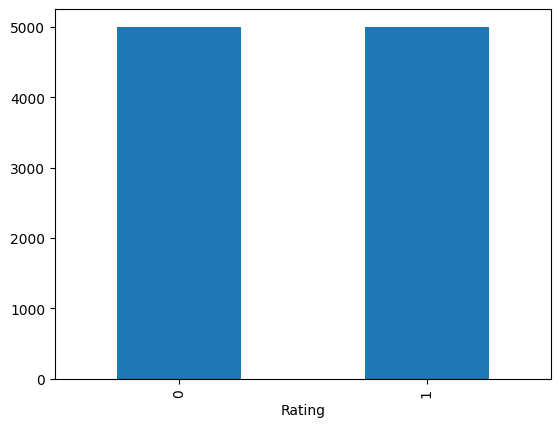

In [31]:
# train 데이터 분포도 보기
import matplotlib.pyplot as plt
print(train['Rating'].value_counts())
train['Rating'].value_counts().plot(kind='bar')

In [32]:
# 결측치 제거 후 인덱스 재정렬
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [33]:
# 리뷰 텍스트길이 컬럼추가
train['length'] = train['Review'].apply(lambda x: len(str(x)))
test['length'] = test['Review'].apply(lambda x: len(str(x)))

In [34]:
#길이 5미만 삭제
train = train.loc[train['length']>5]
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9920 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  9920 non-null   int64 
 1   Review  9920 non-null   object
 2   length  9920 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 310.0+ KB


In [ ]:
#길이 5미만 삭제
test = test.loc[test['length']>5]
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2975 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  2975 non-null   int64 
 1   Review  2975 non-null   object
 2   length  2975 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 93.0+ KB


In [35]:
train = train.drop(['length'], axis=1)
train = train.reset_index(drop=True)
train

,Rating,Review
0,0,장점 외국 휴양지에 잘 안 가본 사람에게는 괜찮을 듯 단점 1. 외국 휴양지에 자...
1,0,가벼운 맛. 실망하고 먹고 나오면서 대기하는 사람들한테 다른 곳으로 가라고 하고 싶었다.
2,0,카페 뷰는 너무 좋으나 아인슈페너는 크림은 차갑고 커피는 뜨거워서 믹스하니 이도 저...
3,0,닭칼 별로던데요..
4,0,안양 토박이들은 알 겁니다 중앙시장 김밥 다 거기서 거긴 거 곱창골목 뒤쪽 김밥 ...
...,...,...
9915,1,수제 비시 원한 맛. 감자 전. 국물이 시원하고 아주 맛있었음. 창모 로랑 맛 비슷...
9916,1,서촌 올 때마다 먹는 통인 스위트. 에그타르트를 좋아해서 여기저기 많이 먹어본 편인...
9917,1,정말 맛나게 배부르게 잘 먹음 직원들도 다 친절하고 무한리필 김치 전과 콘치즈 다음...
9918,1,좀 비싸긴 한데 너무 달지 않고 맛남. 계속 먹어도 질리지 않고 또 먹고 싶은 맛


In [36]:
test = test.drop(['length'], axis=1)
test = test.reset_index(drop=True)
test

,Rating,Review
0,0,"미쉐린 받은 집이라는데... 예약도 안되고, 먼저 와서 자리 잡으려는데 전체 인원이..."
1,0,30분 웨이팅 음식 주문하고 나오는데 230분 .. 굳이 기다려서 먹을 맛도 아니고...
2,0,장사 왜 하세요 궁금해서 물어보는 거예요 홀 알바들은 왜 이렇게 시끄럽고 주방은 대...
3,0,최악의 식사를 하고 왔습니다 리뷰 믿고 갔다가 맛 집은커녕 비빔과 물 막국수를 시켜...
4,0,"돼지 냄새가 너무 심해서... 전복 해장국은 간도 안 되어있고, 김치는 너무 다 짜..."
...,...,...
2995,1,맛 기본 쌀국수의 경우 맛이 진하고 뼈만이 우러나와 상당히 맛이 좋았다. 매콤한 ...
2996,1,구성비가 좋아요. 월요일은 쉬니까 가실 분들은 꼭 참고하세요
2997,1,전통 평양은 아니고 약간 퓨전 평양 능라도와 비슷한 스타일 처음은 동치미 끝은 육향...
2998,1,꽤나 오래된 의정부시장 근처 손칼 국숫집 수제비와 김치만두 칼국수가 맛있는 집. 직...


In [37]:
train.rename(columns={'Rating': 'label', 'Review': 'document'}, inplace=True)

In [38]:
test.rename(columns={'Rating': 'label', 'Review': 'document'}, inplace=True)

In [39]:
display(train.head(2))
display(test.head(2))

,label,document
0,0,장점 외국 휴양지에 잘 안 가본 사람에게는 괜찮을 듯 단점 1. 외국 휴양지에 자...
1,0,가벼운 맛. 실망하고 먹고 나오면서 대기하는 사람들한테 다른 곳으로 가라고 하고 싶었다.


,label,document
0,0,"미쉐린 받은 집이라는데... 예약도 안되고, 먼저 와서 자리 잡으려는데 전체 인원이..."
1,0,30분 웨이팅 음식 주문하고 나오는데 230분 .. 굳이 기다려서 먹을 맛도 아니고...


## kykim/bert-kor-base 모델 사용

In [40]:
model_name = 'kykim/bert-kor-base'

In [41]:
import torch
from transformers import BertTokenizerFast
from torch.utils.data import Dataset, DataLoader

class Tokenizing(Dataset):
  # init 함수 생성
  def __init__(self, data, model_name):
    self.data = data # document, label로 구성된 dataframe 전달
    self.tokenizer = BertTokenizerFast.from_pretrained(model_name) # Huggingface 토크나이저 생성

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sentence = self.data.iloc[idx]['document'] #iloc : dataframe 정수기반 위치 인덱싱
    label = self.data.iloc[idx]['label']

    # 토크나이징
    tokens = self.tokenizer(
        sentence,               # 1개 문장
        return_tensors='pt',    # 텐서로 반환
        truncation=True,        # 잘라내기 적용
        padding='max_length',   # padding 적용
        add_special_tokens=True # 스페셜 토큰 적용
    )

    input_ids = tokens['input_ids'].squeeze(0)          #2D->1D
    attention_mask = tokens['attention_mask'].squeeze(0)#2D->1D
    token_type_ids = torch.zeros_like(attention_mask) # 단일문장 처리
    # BERT는 두개 문장 입력시 0과1로 구분함. 위 코드로 어텐션마스크 크기만큼의 0텐서를 생성하여 단일문장만 처리하도록함.

    return {
        'input_ids' : input_ids,
        'attention_mask' : attention_mask,
        'token_type_ids' : token_type_ids,
    }, torch.tensor(label)

In [42]:
train_data = Tokenizing(train, model_name)
test_data = Tokenizing(test, model_name)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/344k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [43]:
#inputs는 입력으로 들어가는 x데이터
#inputs.keys = dict_keys(['input_ids', 'attention_mask', 'token_type_ids'])

# k,v in inputs.items()에서
# k : inputs.items 이름
# v : items의 tensors

inputs, label = next(iter(train_loader))
for k, v in inputs.items():
  print('printing k---\n',k)
  print('printing v---\n',v)

print('------')
print(inputs.keys())
print(inputs)
print('---')
print(label)

printing k---
 input_ids
printing v---
 tensor([[    2, 26124, 14000,  ...,     0,     0,     0],
        [    2, 25757, 27615,  ...,     0,     0,     0],
        [    2, 24723,  8027,  ...,     0,     0,     0],
        ...,
        [    2, 15813,  4563,  ...,     0,     0,     0],
        [    2,  4038, 14624,  ...,     0,     0,     0],
        [    2, 36969, 14134,  ...,     0,     0,     0]])
printing k---
 attention_mask
printing v---
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
printing k---
 token_type_ids
printing v---
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------
dict_keys(['input_ids', 'attention_mask', 'token_type_ids'])
{'in

In [44]:
from transformers import BertConfig

config = BertConfig.from_pretrained(model_name)
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "embedding_size": 768,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 42000
}

In [45]:
from transformers import BertModel
import torch
import torch.nn as nn
import torch.optim as optim

class CustomBert(nn.Module):
  def __init__(self, model_name, dropout_rate=0.5):
    # 부모 클래스 초기화
    super(CustomBert, self).__init__()
    # Pre-Trained 모델 지정
    self.bert = BertModel.from_pretrained(model_name)
    # dropout 설정하기
    self.dr = nn.Dropout(p=dropout_rate)
    # 최종 출력층 정의 (768,2)
    # 768은 BERT모델의 'hidden_size'이며, 모델의 마지막 은닉층에서 나오는 특징 벡터의 차원수이다.
    # 2는 최종적으로 분류하고자하는 클래스의 수를 의미한다.
    self.fc = nn.Linear(768, 2)

  def forward(self, input_ids, attention_mask, token_type_ids):
    # 입력을 pre-trained bert model 로 대입
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    # 결과의 last_hidden_state 가져옴
    last_hidden_state = output['last_hidden_state']
    # last_hidden_state[:, 0, :]는 [CLS] 토큰을 가져옴
    x = self.dr(last_hidden_state[:, 0, :])
    # FC 을 거쳐 최종 출력
    x = self.fc(x)

    return x

In [46]:
# CustomBert 모델 만들기
bert = CustomBert(model_name)
# bert.to(device)
bert.cuda()

pytorch_model.bin:   0%|          | 0.00/476M [00:00<?, ?B/s]

CustomBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(bert.parameters(), lr=1e-5)

In [48]:
from tqdm import tqdm

def train_model(model, data_loader, loss_fn, optimizer):
  model.train()

  running_loss = 0
  corr = 0
  counts = 0

  # 보기좋게 progress bar로 출력. 안쓸거면 그냥 data_loader 밑에 넣으면 됨.
  progress_bar = tqdm(data_loader, unit='batch', total=len(data_loader), mininterval=1)

  # inputs과 labels 데이터 cuda에 올림
  for idx, (inputs, labels) in enumerate(progress_bar): #progressbar 사용안하면 data_loader 바로 넣어주면됨.
    # inputs = {k:v.to(device) for k, v in inputs.items()}
    # labels = labels.to(device)

    inputs = {k:v.cuda() for k,v in inputs.items()}
    labels = labels.cuda()


    # zero_grad
    optimizer.zero_grad()

    # forward
    output = model(**inputs)

    # 손실함수로 손실 계산
    loss = loss_fn(output, labels)

    # backward(역전파)
    loss.backward()

    # 계산된 gradient 업데이트
    optimizer.step()

    # output.max(dim=1)은 output 각 행에서의 최대값을 찾음. 반환값 = 최대확률, 인덱스
    # 여기서 잘 예측했는지 대조하기 위해 인덱스값만 쓸거임.
    _, pred = output.max(dim=1)

    # 예측한 index와 label을 대조하고, 정확하게 맞춘것만 .item()으로 tensor에서 값추출하고 corr 변수에 누적
    corr += torch.sum(pred.eq(labels)).item()

    # loss_fn(output, labels).item()으로 loss 값 추출
    # labels.size(0) : batch_size
    # loss * batch_size = 1개 배치의 전체 loss값.
    # running_loss에 loss값들을 누적 -> 평균 loss 산출을 위함
    running_loss += loss_fn(output, labels).item() * labels.size(0)

  # 누적합들을 전체 데이터셋 숫자로 나눠 평균 loss와 최종 정확도를 산출
  val_loss = running_loss / len(data_loader.dataset)
  val_acc = running_loss / len(data_loader.dataset)

  return val_loss, val_acc

In [49]:
def evaluate_model(model, data_loader, loss_fn):
  model.eval()

  with torch.no_grad():
    # loss와 accuracy 산출해야함
    corr = 0
    running_loss = 0

    for inputs, labels in data_loader:
      # inputs = {k:v.to(device) for k,v in inputs.items()}
      # labels = labels.to(device)

      inputs = {k:v.cuda() for k,v in inputs.items()}
      labels = labels.cuda()


      # forward
      output = model(**inputs)

      # loss, accuracy 계산
      _, pred = output.max(dim=1)
      corr += torch.sum(pred.eq(labels)).item()
      running_loss += loss_fn(output, labels).item() * labels.size(0)

    loss = running_loss / len(data_loader.dataset)
    acc = corr / len(data_loader.dataset)

  return loss, acc

In [ ]:
# 훈련 epoch 설정
num_epochs = 3

my_model = 'customBert'
min_loss = np.inf

for epoch in range(num_epochs):

  train_loss, train_acc = train_model(bert, train_loader, loss_fn, optimizer)
  val_loss, val_acc = evaluate_model(bert, test_loader, loss_fn)

  if val_loss < min_loss:
    print(f'loss가 {min_loss:.5f}에서 {val_loss:.5f}로 갱신되었으므로, model를 업데이트합니다!')
    min_loss = val_loss
    torch.save(bert.state_dict(), f'{my_model}.pth')

  print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 1242/1242 [14:54<00:00,  1.39batch/s]


loss가 inf에서 0.15995로 갱신되었으므로, model를 업데이트합니다!
epoch 01, loss: 0.21781, acc: 0.21781, val_loss: 0.15995, val_accuracy: 0.94958


100%|██████████| 1242/1242 [14:52<00:00,  1.39batch/s]


loss가 0.15995에서 0.15067로 갱신되었으므로, model를 업데이트합니다!
epoch 02, loss: 0.12051, acc: 0.12051, val_loss: 0.15067, val_accuracy: 0.95227


100%|██████████| 1242/1242 [14:52<00:00,  1.39batch/s]


epoch 03, loss: 0.07978, acc: 0.07978, val_loss: 0.16637, val_accuracy: 0.94756


# **test**

In [84]:
import torch.nn.functional as F

class CustomPredictor():
  def __init__(self, model, tokenizer, labels:dict):
    self.model = model
    self.tokenizer = tokenizer
    self.labels = labels

  def predict(self, sentence):
    tokens = self.tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        add_special_tokens=True
    )
    tokens = {k:v.cuda() for k,v in tokens.items()}
    # tokens.to(device)
    # tokens.cuda()
    # prediction = self.model(**tokens)
    # 모델 예측 수행
    logits = self.model(**tokens)
    # print(prediction) tensor([[ 2.9543, -3.3106]], device='cuda:0', grad_fn=<AddmmBackward0>)
    prediction = F.softmax(logits, dim=1)
    # print(prediction) tensor([[0.9981, 0.0019]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
    output = prediction.argmax(dim=1).item()
    # print(output)      0
    prob, result = prediction.max(dim=1)[0].item(), self.labels[output]
    print(f'[{result}] -- 확률은: {prob*100:.3f}% 입니다.')
    # print(prob)        0.9981016516685486
    #print(result)      #부정 리뷰 입니다.
    positivity = prediction[0][1].item()
    print(positivity)
    return positivity

In [85]:
model_path = '/content/drive/MyDrive/big_project/customBert.pth'  # 모델 가중치 파일 경로 설정

# 저장한 state_dict를 bert 모델에 load -> 진짜 내 모델!!
bert.load_state_dict(torch.load(model_path))

tokenizer = BertTokenizerFast.from_pretrained(model_name)

labels = {
    0: '부정 리뷰 입니다.',
    1: '긍정 리뷰 입니다.'
}

predictor = CustomPredictor(bert, tokenizer, labels)

In [52]:
negative = '이 영화는 정말 더럽게 재미없네... 다신 안보련다 비추!'
positive = '인생 최고의 영화였다. 진짜 배우들의 명연기가 돋보이는 영화'

In [53]:
predictor.predict(negative)

[부정 리뷰 입니다.] -- 확률은: 99.860% 입니다.


In [ ]:
a = predictor.predict(positive)

긍정 리뷰 입니다.


In [ ]:
input_sentence = input('문장을 입력해 주세요: ')
predictor.predict(input_sentence)

문장을 입력해 주세요: 종종 가던곳인데 감기걸려서 몸보신겸 먹고왔습니다. 개인적으로 김치류도 많이 먹고 부추.매운고추.들깨가루 많이 넣어먹는데... 여긴 따로 비치된게  없어서 아쉬워요. 계속 부탁드려야 한다는게 단점입니다. 그래도 삼뿌리도 주시고..진한국물에 잘먹었어요~ 묵도 맛있었어요~
[긍정 리뷰 입니다.]
확률은: 99.545% 입니다.


# **NAVER REVIEW 테스트 **

In [69]:
df_naver = pd.read_csv('/content/drive/MyDrive/big_project/naver_review(0~30).csv')

In [70]:
df_naver

,콘텐츠명,시군,구명,새주소[도로명 주소],지번주소,키워드,좌표[X],좌표[Y],전화번호,웹URL,...,유아용품,영업시간,상세설명,주차가능여부,중분류,대분류,실내_실외,query,review,review_count
0,대물림남원추어탕,서울특별시,강북구,서울특별시 강북구 도봉로 192,서울특별시 강북구 미아동 121-27,"#어린이,#가족",127.026700,37.625963,02-945-1292,NaN,...,유아의자1개,"평일, 주말, 공휴일\n11:00~22:00",가족이 함게 즐기는 직접 만드는 맛깔스런 한끼,O,한식,먹기,실내,서울특별시 강북구 도봉로 192 대물림남원추어탕,['종종 가던곳인데 감기걸려서 몸보신겸 먹고왔습니다. 개인적으로 김치류도 많이 먹고...,[328]
1,롯데리아 숙대입구역,서울특별시,용산구,서울특별시 용산구 한강대로 283,서울특별시 용산구 갈월동 89-9,"#어린이,#가족",126.971943,37.543368,02-718-9861,https://www.lotteria.com/,...,"유아용의자2개보유\n포크,보유,나이프\n구비",연중무휴 24시간,부모와 아이들이 모두 즐거운 곳.\n맛있는 즐거움 롯데리아입니다.,X,패스트푸드,먹기,실내,서울특별시 용산구 한강대로 283 롯데리아 숙대입구역,['양념감자는 너무나도 잘 아는 맛있는 맛이고 망고토네이도가 미쳤어요... 비싸긴하...,[121]
2,목동카츠,서울특별시,양천구,서울특별시 양천구 목동로9길 4,서울특별시 양천구 신정동 1008-16,"#어린이,#가족",126.864100,37.523050,02-2039-0635,NaN,...,유아의자 1개\n포크수저세트,"평일, 주말, 공휴일\n11:30~21:30","제주흑돼지 전문\n돈가스, 우동, 음료",O,한식,먹기,실내,서울특별시 양천구 목동로9길 4 목동카츠,['작년부터 방문하는 돈가스 최애맛집입니다..🤍🤍 1. 양배추 샐러드 진짜 싱싱하고...,[220]
3,참나무본가,서울특별시,강동구,서울특별시 강동구 고덕로 421,서울특별시 강동구 강일동 727,"#어린이,#가족",127.172552,37.557418,02-477-6785,NaN,...,유아의자4개,"평일, 주말, 공휴일\n11:30~22:30",NaN,O,한식,먹기,실내,서울특별시 강동구 고덕로 421 참나무본가,검색불가,0
4,KKD 메세나폴리스점,서울특별시,마포구,서울특별시 마포구 양화로 45,서울특별시 마포구 서교동 490,"#어린이,#가족",126.913769,37.550747,02-3143-5803,https://www.krispykreme.co.kr/,...,유아용 의자 2개 비치,"평일, 주말, 공휴일\n08:00~22:00",NaN,X,제과,먹기,실내,서울특별시 마포구 양화로 45 KKD 메세나폴리스점,검색불가,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,미가양꼬치,서울특별시,노원구,서울특별시 노원구 석계로 31,서울특별시 노원구 월계동 73-13,"#어린이,#가족",127.063880,37.617530,NaN,NaN,...,NaN,NaN,NaN,X,중식,먹기,실내,서울특별시 노원구 석계로 31 미가양꼬치,NaN,NaN
598,풍년참숯불갈비,서울특별시,서초구,서울특별시 서초구 서초대로74길 29,서울특별시 서초구 서초동 1327-29,"#어린이,#가족",127.027440,37.494950,02-566-6630,NaN,...,"돼지갈비,계란찜","평일, 주말, 공휴일\n10:00~22:00\n브레이크타임 15:00~16:00",NaN,O,한식,먹기,실내,서울특별시 서초구 서초대로74길 29 풍년참숯불갈비,NaN,NaN
599,대흥정육식당,서울특별시,중랑구,서울특별시 중랑구 중랑천로10길 24,서울특별시 중랑구 면목동 186-149,"#어린이,#가족",127.074480,37.591790,02-435-6288,NaN,...,유아의자,"평일, 주말, 공휴일\n10:00 ~ 22:00",국내산 재료만을 사용하여 온 가족이 안심하고 먹을 수 있는 식당,X,한식,먹기,실내,서울특별시 중랑구 중랑천로10길 24 대흥정육식당,NaN,NaN
600,엔제리너스 김포공항1층,서울특별시,강서구,서울특별시 강서구 하늘길 177,서울특별시 강서구 공항동 1373-5,"#어린이,#가족",126.808473,37.556756,02-2667-0108,https://www.angelinus.com/,...,"유아용의자 1개\n포크, 나이프 구비","평일, 주말, 공휴일\n05:30~22:00",NaN,X,카페,먹기,실내,서울특별시 강서구 하늘길 177 엔제리너스 김포공항1층,NaN,NaN


In [86]:
# 문자열 처리를 통해 개별 리뷰 추출
reviews_str = df_naver['review'][0]  # 데이터프레임에서 첫 번째 리뷰 문자열 가져오기
reviews_list = eval(reviews_str)  # 문자열을 리스트로 변환
score = []
goodbad = []
p = 0
# 개별 리뷰 출력
for idx, review in enumerate(reviews_list, start=1):
    text = review
    print(f'Review {idx}: {review}')
    p += predictor.predict(text)
    print('\n')

print(p/len(reviews_list))

Review 1: 종종 가던곳인데 감기걸려서 몸보신겸 먹고왔습니다. 개인적으로 김치류도 많이 먹고 부추.매운고추.들깨가루 많이 넣어먹는데... 여긴 따로 비치된게 
없어서 아쉬워요. 계속 부탁드려야 한다는게 단점입니다. 그래도 삼뿌리도 주시고..진한국물에 잘먹었어요~ 묵도 맛있었어요~
[긍정 리뷰 입니다.] -- 확률은: 99.816% 입니다.
0.9981645941734314


Review 2: 탕이 맛있고 간이 잘 맞아요
[긍정 리뷰 입니다.] -- 확률은: 99.581% 입니다.
0.9958147406578064


Review 3: 추어탕 맛있고 간도 잘 맞고 사장님 친절해요
[긍정 리뷰 입니다.] -- 확률은: 99.766% 입니다.
0.9976565837860107


Review 4: 맛있고 주차공간 편리해요
[긍정 리뷰 입니다.] -- 확률은: 99.844% 입니다.
0.9984368681907654


Review 5: 맛있고 매장이 깨끗해요
[긍정 리뷰 입니다.] -- 확률은: 99.810% 입니다.
0.9981042146682739


Review 6: 추어탕 한그릇 ㅇ 포장이요 윈기가 없는거 같아서 ㅋ
[긍정 리뷰 입니다.] -- 확률은: 59.045% 입니다.
0.590451717376709


Review 7: 친절하고 음식이 맛이있어요.
[긍정 리뷰 입니다.] -- 확률은: 99.567% 입니다.
0.9956719875335693


Review 8: 굳
[긍정 리뷰 입니다.] -- 확률은: 99.448% 입니다.
0.9944754242897034


Review 9: 맛있게 잘먹었습니다.김치랑 깍두기도 맛있어요.
[긍정 리뷰 입니다.] -- 확률은: 99.633% 입니다.
0.9963334798812866


Review 10: 좋아요. 여사장님 친절하세요
[긍정 리뷰 입니다.] -- 확률은: 99.257% 입니다.
0.992570698261261


Review 11: 좋아요
[긍정 리뷰 입니다.] -- 확률은: 99.781% 